In [63]:

import numpy as np #linear algebra
from matplotlib import pyplot as plt # 2D plotting library
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt
from skimage.color import rgb2gray
from glob import glob
from skimage.io import imread
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import os,sys
import seaborn as sn  # heatmap
import tensorflow as tf   
from PIL import Image

In [70]:
# !pip install git+git://github.com/fchollet/keras.git --upgrade
# !pip install tensorflow
# !pip install np_utils
# !pip install enum34
# !pip install opencv-python

In [2]:
import os
os.environ['KERAS_BACKEND']='tensorflow'
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from tensorflow.python.keras.layers import Dense, Dropout, Flatten
from tensorflow.python.keras.preprocessing import image
from tqdm import tqdm
import cv2    
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam

In [3]:
#resizing all the images
# dir path
root_dir = '/Users/supriyajain/Desktop/257/Project/yelp_photos/photos/'

for filename in glob.iglob(root_dir + '/*.jpg'):
    #opening an image from the drive
    im = Image.open(filename)
    #resizing it
    imResize = im.resize((75,75), Image.ANTIALIAS)
    #saving image back to drive
    imResize.save(filename , 'JPEG', quality=90)

In [23]:
# Enter Directory of all images 
img_dir = '/Users/supriyajain/Desktop/257/Project/yelp_photos/photos' 

data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)

# creaing dictionary with key as photo_id and value as image path
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x 
                     for x in glob.glob(data_path)}

In [67]:
# Here's our 6 categories that we have to classify.
# class_names = ['inside', 'outside', 'food', 'drink', 'menu']
class_names = ['drink', 'food', 'inside', 'menu', 'outside']
class_names_label = { 0:'drink',
                      1: 'food',
                      2: 'inside',
                      3: 'menu',
                      4: 'outside',
                    }
nb_classes = 5

In [28]:
#reading json files
photos_json = '/Users/supriyajain/Desktop/257/Project/photo.json'

df = pd.read_json(photos_json, lines=True)

### Exploring the dataset

In [29]:
# getting shape of the datafram
df.shape

(200000, 4)

In [31]:

#converting labels to categorical variables
df['class_names_label'] = pd.Categorical(df['label']).codes

# for each photo_id getting the corresponding path from the dictionary
df['path'] = df['photo_id'].map(imageid_path_dict.get)

# dropping all the rows for which path does not exists
df = df.dropna()

# getting an image from the path
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x)))

df.head(3)


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,business_id,caption,label,photo_id,class_names_label,path,image
0,rcaPajgKOJC2vo_l3xa42A,,inside,MllA1nNpcp1kDteVg6OGUw,2,/Users/supriyajain/Desktop/257/Project/yelp_ph...,"[[[98, 67, 99], [134, 109, 128], [115, 105, 10..."
1,Kn23LDd740SBVJ7mum0fwg,,inside,YjxBE88Bf6CmTEF2LP1UNA,2,/Users/supriyajain/Desktop/257/Project/yelp_ph...,"[[[115, 126, 158], [135, 131, 164], [157, 140,..."
2,ZkGDCVKSdf8m76cnnalL-A,,food,1f7izSjM0WjkDRIVbPy1yw,1,/Users/supriyajain/Desktop/257/Project/yelp_ph...,"[[[236, 196, 160], [232, 197, 165], [223, 196,..."


In [36]:
df.to_csv('combined_json_and_images_all.csv')

In [37]:
df.shape

(193006, 7)

In [96]:
x= df.drop(columns=['class_names_label'],axis=1)
y= df['class_names_label']

In [34]:
x_train_o, x_test_o, y_train , y_test  = train_test_split(x, y, test_size=0.20, random_state=42)

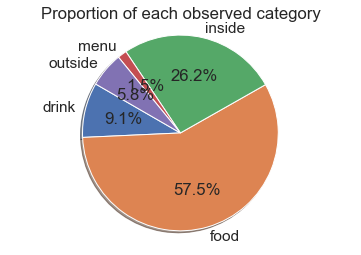

In [68]:
# Plot a pie chart to check proporation of each observed category

sizes = np.bincount(y)
explode = (0, 0, 0, 0, 0, 0)  
plt.pie(sizes, explode=None, labels=class_names,
autopct='%1.1f%%', shadow=True, startangle=150)
plt.axis('equal')
plt.title('Proportion of each observed category')

plt.show()

In [38]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [39]:
# reshaping the data
x_train = x_train.reshape(x_train.shape[0], *(75, 75, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 75, 3))

### Displaying an random image from the training set.

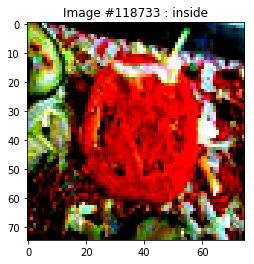

In [40]:
index = np.random.randint(x_train.shape[0])
plt.figure()
plt.imshow(x_train[index])
plt.grid(False)
plt.title('Image #{} : '.format(index) + class_names_label[y_train[index]])
plt.show()

### Display the first 5 images from the training set .

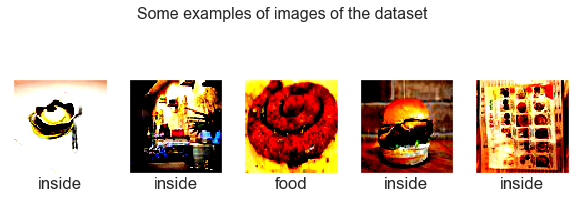

In [76]:
fig = plt.figure(figsize=(10,10))
fig.suptitle("Some examples of images of the dataset", fontsize=16)
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names_label[y_train[i]])
plt.show()

### Implementing CNN to classify images

### 1) Build the model

- Conv2D: (32 filters of size 3 by 3) The features will be "extracted" from the image.
- MaxPooling2D: The images get half sized.
- Flatten: Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values.
- Relu : given a value x, returns max(x, 0).
- Softmax: 6 neurons, probability that the image belongs to one of the classes.

In [42]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (75  , 75, 3)), # the nn will learn the good filter to use
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])

### 2) Compile the model

In [43]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

### 3) Train / fit the data to the model 

In [44]:
history = model.fit(x_train, y_train, batch_size=128, epochs=5, validation_split = 0.2)

Train on 123523 samples, validate on 30881 samples
Epoch 1/5
123523/123523 [==============================]123523/123523 [==============================] - 2319s 19ms/step - loss: 0.5199 - acc: 0.8220 - val_loss: 0.4903 - val_acc: 0.8351

Epoch 2/5
123523/123523 [==============================]123523/123523 [==============================] - 2269s 18ms/step - loss: 0.3775 - acc: 0.8710 - val_loss: 0.4047 - val_acc: 0.8626

Epoch 3/5
123523/123523 [==============================]123523/123523 [==============================] - 3161s 26ms/step - loss: 0.3151 - acc: 0.8905 - val_loss: 0.3641 - val_acc: 0.8762

Epoch 4/5
123523/123523 [==============================]123523/123523 [==============================] - 2896s 23ms/step - loss: 0.2615 - acc: 0.9087 - val_loss: 0.3764 - val_acc: 0.8752

Epoch 5/5
123523/123523 [==============================]123523/123523 [==============================] - 3235s 26ms/step - loss: 0.2057 - acc: 0.9280 - val_loss: 0.4263 - val_acc: 0.8697



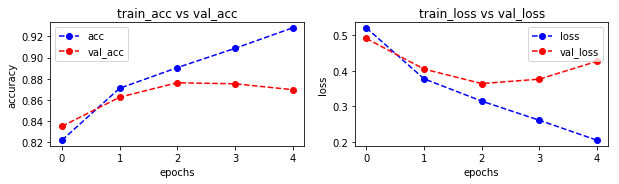

In [45]:
fig = plt.figure(figsize=(10,5))
plt.subplot(221)
plt.plot(history.history['acc'],'bo--', label = "acc")
plt.plot(history.history['val_acc'], 'ro--', label = "val_acc")
plt.title("train_acc vs val_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()

plt.subplot(222)
plt.plot(history.history['loss'],'bo--', label = "loss")
plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")


plt.legend()
plt.show()

### 4) Evaluate the model on the testing set

In [47]:
test_loss = model.evaluate(x_test, y_test)

38602/38602 [==============================]38602/38602 [==============================] - 212s 5ms/step



In [77]:
test_loss

[0.4212868938167616, 0.8714833428319776]

##  Accuracy on testing set: 87% and Loss : 42%

### 5) Error analysis of the model.

### Lets check on which kind of images the classifier has trouble in classification.

In [60]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):

    #Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of mislabeled images by the classifier:", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(mislabeled_images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[mislabeled_labels[i]])
    plt.show()

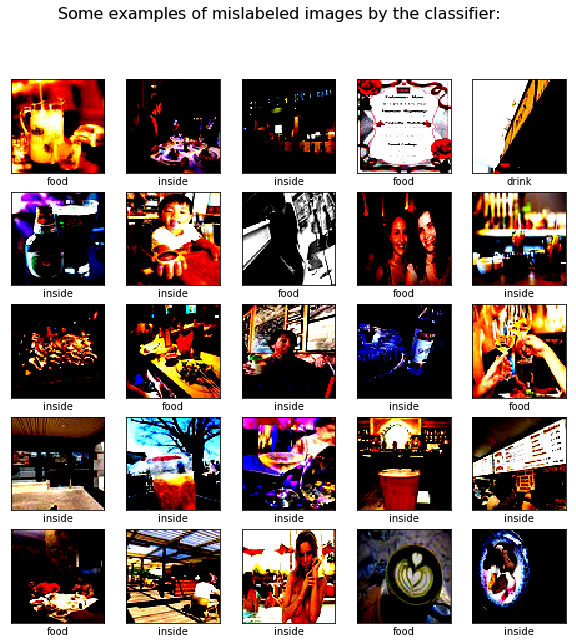

In [61]:
#Predicting labels for test images
predictions = model.predict(x_test)
pred_labels = np.argmax(predictions, axis = 1)
print_mislabeled_images(class_names_label, x_test, y_test, pred_labels)

### Creating confusion matrix

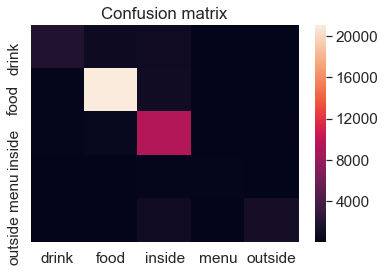

In [91]:
CM = confusion_matrix(y_test, pred_labels)
ax = plt.axes()
sn.set(font_scale=1.4)
sn.heatmap(CM, annot=False,annot_kws={"size": 16},  xticklabels=class_names, yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()